In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.optimize import fsolve

Let's declare a bunch of constants

In [2]:
# 1D EDO for Fold bifurcation paramaters
a1 = -1
a2 = 1

# 2D EDO for Hopf bifurcation parameters
b1 = b2 = 1
c1 = -1
c2 = 1

# initial conditions
x0 = 0.0
y0 = 5.0
z0 = 5.0

r0 = 5.0

# time range
t_init = 0
t_fin = 500
time_step = 0.01

Let's write our EDOs

In [3]:
# linear coupling parameter
# proposed by Dekker et al. article
def gamma(x):
    return (-0.1 + 0.12*x)

def fold(v, phi):
  return np.array([
    a1 * (v[0] ** 3) + a2 * v[0] + phi
  ])

def hopf(v, phi):
  return np.array([
    phi * v[0] - (v[0] ** 3),
  ])

def hopf_coupled(v, gamma, phi):
  rsquared = v[1] ** 2 + v[2] ** 2
  return np.array([
    gamma(v[0]) * rsquared - (rsquared ** 3)
  ])

# v is a vector \vec{v}: [x, y, z]
def fold_hopf_polar(v, gamma, phi):
  rsquared = v[1] ** 2 + v[2] ** 2
  return np.array([
    a1 * (v[0] ** 3) + a2 * v[0] + phi,
    gamma(v[0]) * rsquared - (rsquared ** 3)
  ])

# v is a vector \vec{v}: [x, y, z]
def fold_hopf(v, gamma, phi):
  return np.array([
    a1 * (v[0] ** 3) + a2 * v[0] + phi,
    b1*v[2] + b2*(gamma(v[0]) - (v[1]**2 + v[2]**2))*v[1],
    c1*v[1] + c2*(gamma(v[0]) - (v[1]**2 + v[2]**2))*v[2]
  ])

We use RK4 method to solve our non-linear systems of EDOs

In [4]:
def rk4_derivatives(edo, time_step, v, *args):
  k1 = edo(v, *args)
  k2 = edo(v + ((time_step / 2) * k1), *args)
  k3 = edo(v + ((time_step / 2) * k2), *args)
  k4 = edo(v + (time_step * k3), *args)
  return (k1 + 2*k2 + 2*k3 + k4)

def rk4(edo, time_step, v, *args):
  return (time_step / 6) * rk4_derivatives(edo, time_step, v, *args)

Time serie

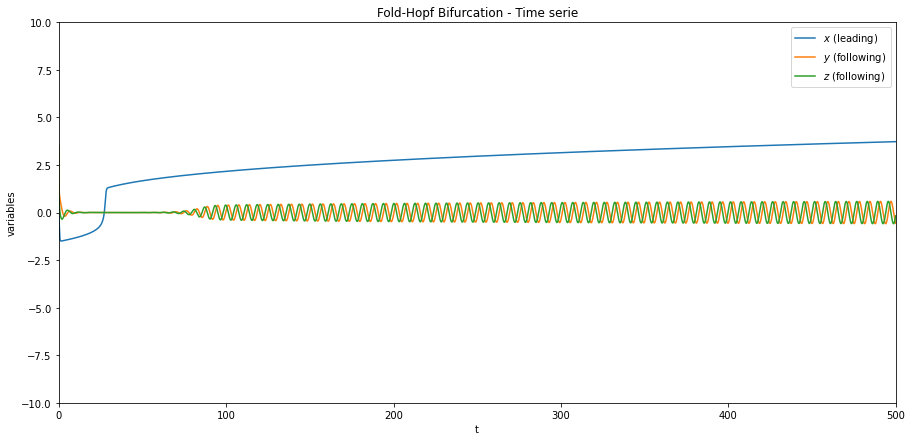

In [8]:
class time_series():
  def __init__(self):
    # initial conditions
    self.initial_conditions = np.array([[x0, y0, z0]])
    # forcing parameter
    self.phi = -2
    # time
    self.t_init = t_init
    self.t_fin = t_fin
    self.time_step = time_step
    # data
    self.dataset = self.initial_conditions
    self.time_range = np.arange(t_init, t_fin + time_step, time_step)
    self.legends = ["$x$ (leading)", "$y$ (following)", "$z$ (following)"]

    
  def rk4(self):
    # [x0, y0, z0]
    v = self.initial_conditions[0]

    for t in self.time_range:
      if t == self.t_fin: break # LOL

      # increase forcing parameter
      self.phi += 0.001

      v += rk4(fold_hopf, self.time_step, v, gamma, self.phi)
      self.dataset = np.append(self.dataset, [v.copy()], axis=0)

    self.plot()

  def plot(self):
    fig, ax = plt.subplots(figsize=(15, 7))

    l1, = ax.plot(self.time_range, self.dataset[:,0])
    l2, = ax.plot(self.time_range, self.dataset[:,1])
    l3, = ax.plot(self.time_range, self.dataset[:,2])

    plt.xlabel("t")
    plt.ylabel("variables")
    plt.xlim(0,500)
    plt.ylim(-10,10)
    plt.legend(self.legends, loc="upper right")
    plt.title("Fold-Hopf Bifurcation - Time serie")
    plt.show()

time_serie = time_series()
time_serie.rk4()

Let's do our bifurcations

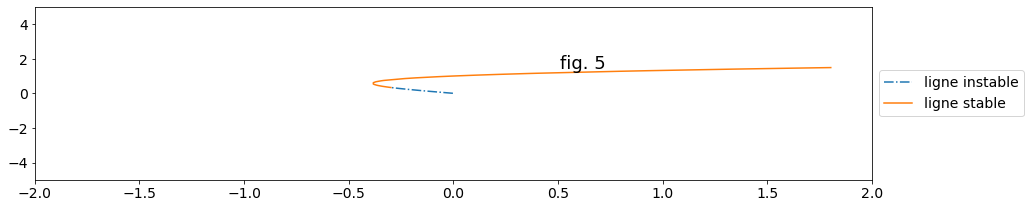

In [8]:
phi = 0
nphi = 1000
nguesses = 3
phi_mesh = np.linspace(start=-2, stop=2, num=nphi)

# number of time steps
nt = int((t_fin - t_init) / time_step)
time_mesh = np.linspace(start=t_init, stop=t_fin, num=nt)

fig = plt.figure(figsize=(15,7))
mpl.rc('font', size = 14)

#def bifurcation(edo, phi_list, guess):
#    equilibria_mesh = np.zeros((nphi), nguesses)
#    try:
        
TRESHOLD = 10**-4   
unstable_equ = []
stable_equ = []

def fold_bifurcation(guesses):
    global unstable_equ
    global stable_equ
    for phi in phi_mesh:
        fx_set = []
        for x in np.linspace(0,2,1000):
            fx = a1 * (x ** 3) + a2 * x + phi
            fx_set.append(fx)
            # confident interval
            if -TRESHOLD < fx < TRESHOLD:
                # compute derivative to check the nature of equilibrium
                dfdx = a1 * ((3 * x) ** 2) + a2
                if dfdx > 0: 
                    unstable_equ.append([x, phi])
                if dfdx < 0:
                    stable_equ.append([x, phi])
                    
    unstable_equ = list(zip(*sorted(unstable_equ, key=lambda x: x[0])))
    unstable_equ_phi = unstable_equ[1]
    unstable_equ_x = unstable_equ[0]
    
    stable_equ = list(zip(*sorted(stable_equ, key=lambda x: x[0])))
    stable_equ_phi = stable_equ[1]
    stable_equ_x = stable_equ[0]

    plt.subplot(2, 1, 1)
    plt.xlim(-2, 2)
    plt.ylim(-5, 5)
    plt.plot(unstable_equ_phi, unstable_equ_x, linestyle="dashdot", label="ligne instable")
    plt.plot(stable_equ_phi, stable_equ_x, label="ligne stable")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
def fold_hopf_bifurcation():
    equilibria_mesh = np.zeros((nphi, nguesses))

    # for each phi
    for phi_index in range(0, nphi-1):
      # create mesh
      # x = np.zeros(self.nt)
      # # set initial conditions (for each phi value)
      # x[0] = x0

      # # simulate the system over time
      # for t in range(0, self.nt-1):
      #   x[t+1] = rk4(fold, time_step, t, x, self.phi_mesh[phi_index])
      # jacobian matrix df(p)
      #jac = 

      guesses = np.linspace(start=-3, stop=3, num=nguesses)
      equilibria = []
      
      # look for some equilibria
      for guess in guesses:  
          equilibrium_fold = fsolve(func=fold, x0=[guess], args=(phi_mesh[phi_index]))
          equilibrium_hopf_coupled = fsolve(func=hopf_coupled, x0=[equilibrium_fold, guess, guess], args=(gamma, phi_mesh[phi_index]))
          equilibria.append(equilibrium_fold[0])
          equilibria.append(equilibrium_hopf_coupled[0])

      # add to the mesh
      equilibria_mesh[phi_index] = equilibria

    plot(equilibria_mesh.copy())

def plot(dataset, ylabel):
    fig, ax = plt.subplots(figsize=(15, 7))
    ax.plot(phi_mesh, dataset)
    
    plt.xlabel("$\phi$")
    plt.ylabel(ylabel)
    plt.xlim(-2,2)
    plt.ylim(-5,5)
    plt.show()
    
guesses = np.linspace(start=-3, stop=3, num=nguesses)
    
fold_bifurcation(guesses)
#hopf_bifurcation()
#fold_hopf_bifurcation()

<ipython-input-9-557c52fdf45a>:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2, 1, 1);


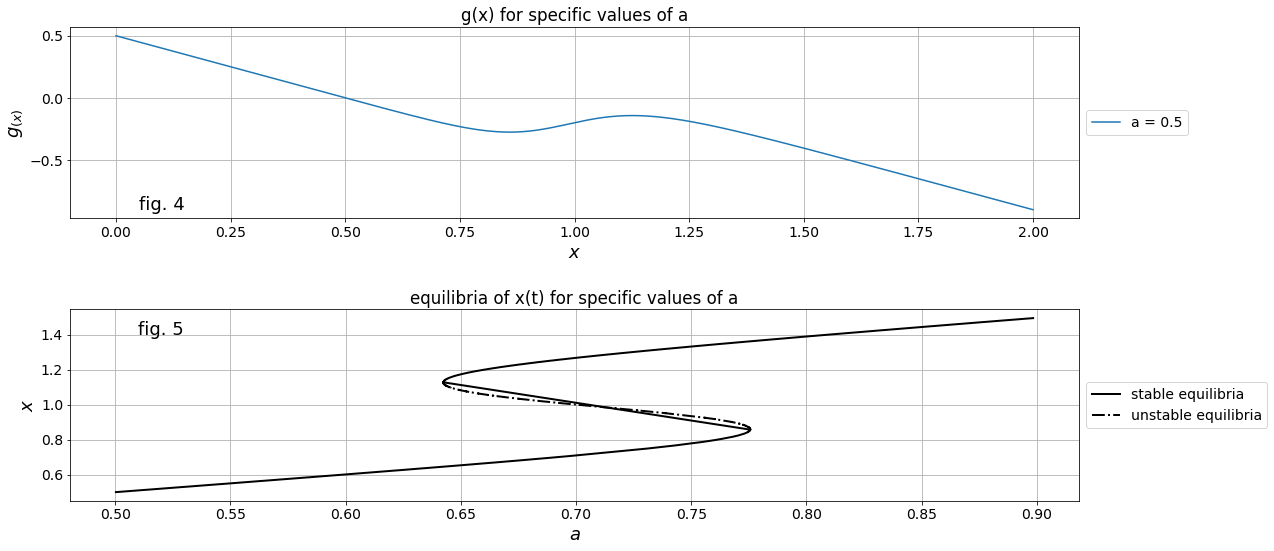

In [9]:
#define parameters and predefine array variables:
h = 1.; b = 1.; p = 12; r = 0.6; A=[]; XA=[]

#vary parameter a in a range of (0.4,0.9):
a = 0.5

fig = plt.figure(figsize=(15,7))
mpl.rc('font', size = 14)

EX1 = []; EX2 = []; EX3 = []

a = 0.5
while a <= 0.9:
    GX = []; X = []
    #calculate g(x) for parameter t in a range of (0,2):
    for x in np.linspace(0,2,1000):
        gx = a-b*x + (r*x**p)/(x**p + h**p)
        GX.append(gx); X.append(x)
        if -10**-4 < gx < 10**-4:
            #calculate g'(x) (= dg(x)/dx) to "check" stability:
            Dgx = -b+(r*p*x**(p-1)*h**p)/((x**p + h**p)**2)
            #write x-coordinate of extremum and depending value of parameter a in an array:
            if Dgx > 0: EX2.append([x,a])      #array for unstable extrema
            if Dgx < 0:   
                EX1.append([x,a])                     
                #if x < 1: EX1.append([x,a])    #array for stable extrema with x<1
                #if x > 1: EX3.append([x,a])    #array for stable extrema with x>1
    #plot f(x) for specific values of a:
    if len(str(a)) == 3:        
        plt.subplot(2, 1, 1)
        plt.plot(X,GX,label = 'a = ' + str(a))
    a += 0.0001

#configure plot properties for subplot(2, 1, 1):
plt.subplot(2, 1, 1);
plt.tight_layout(h_pad=5)
plt.title('g(x) for specific values of a')
plt.xlabel('$x$', fontsize=18)
plt.ylabel('$g_{(x)}$', fontsize=18)
#plt.plot(0, 'k')
plt.grid()
plt.text(0.05, -0.9, 'fig. 4', fontsize=18)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#sort equilibria containing arrays in respect to the increasing order of parameter a:
EX1 = list(zip(*sorted(EX1,key=lambda x: x[0]))); EX1x = EX1[1]; EX1y = EX1[0]
EX2 = list(zip(*sorted(EX2,key=lambda x: x[0]))); EX2x = EX2[1]; EX2y = EX2[0]
#EX3 = list(zip(*sorted(EX3,key=lambda x: x[0]))); EX3x = EX3[1]; EX3y = EX3[0]

#plot curve representing equilibria of x depending on the variation of parameter a:
plt.subplot(2, 1, 2);
#lower part of the curve (stable extrema):
plt.plot(EX1x,EX1y,color = 'k', linewidth=2, label = 'stable equilibria');
#central part of the curve (unstable extrema):
plt.plot(EX2x,EX2y,color = 'k', linewidth=2, label = 'unstable equilibria', linestyle = 'dashdot');
#upper part of the curve (stable extrema):
#plt.plot(EX3x,EX3y,color = 'k', linewidth=2);

#configure plot properties:
plt.title('equilibria of x(t) for specific values of a')
plt.grid();
plt.xlabel('$a$', fontsize=18)
plt.ylabel('$x$', fontsize=18)
plt.text(0.51, 1.4, 'fig. 5', fontsize=18)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))